<a href="https://colab.research.google.com/github/Ferrariagustinpablo/Statistic-related/blob/main/Data_Camp_Case_Study_seismology_Oklah%2C_Kolmogorov_Smirnov_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Gutenberg-Richter Law

The magnitudes of earthquakes ina  given region over a given time period are Exponentially distributed.

The exponential distribution has a single parameter. 

For historical reason seismologist do not use the mean directly, but the mean times the natural logarithm of ten.

b = (/m - mt) ln10

the magnitude mt is the one above which all earthquakes in a region can be detected.

b value is a measure of seismicity. 
most seismically active regions have a b-value right around 1.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import datetime as dt

!pip install dc_stat_think
import dc_stat_think as dcst

In [ ]:
# Import dataset
parkfield_l = 'https://assets.datacamp.com/production/repositories/1067/datasets/dfefd6ab5cf704d0723ec08723c9e7c9978c1700/parkfield_earthquakes_1950-2017.csv'
earthquakes = pd.read_csv(parkfield_l, skiprows=2, parse_dates=['time'])

# Display shape and head
print(earthquakes.shape)
earthquakes.head()

(9991, 26)


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc
0,1951-10-03 13:44:33.170,35.869333,-120.451000,6.0,3.67,ml,6.0,259.0,1.5480,0.43,ci,ci3322265,2016-01-28T18:07:55.760Z,"4km SSW of Parkfield, CA",earthquake,3.85,31.61,0.154,10.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US
1,1953-05-28 07:58:34.510,36.004167,-120.501167,6.0,3.61,ml,7.0,296.0,0.9139,0.39,ci,ci3304011,2016-01-28T18:11:50.020Z,"13km NNW of Parkfield, CA",earthquake,3.28,31.61,NaN,1.0,reviewed,ci,ci,Coalinga,California,Fresno County,US
2,1961-12-14 11:51:15.410,35.970000,-120.470167,6.0,3.95,ml,12.0,297.0,0.8718,0.51,ci,ci3344629,2016-01-28T19:48:08.330Z,"9km NNW of Parkfield, CA",earthquake,3.43,31.61,0.070,11.0,reviewed,ci,ci,Coalinga,California,Fresno County,US
3,1965-02-21 18:39:24.500,35.881000,-120.383500,6.0,3.54,ml,10.0,257.0,1.5380,0.56,ci,ci3330686,2016-01-28T19:32:10.560Z,"5km ESE of Parkfield, CA",earthquake,3.75,31.61,0.048,11.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US
4,1966-06-28 04:18:36.180,35.856500,-120.446167,6.0,3.15,ml,7.0,259.0,1.3120,0.32,ci,ci3330125,2016-01-28T19:32:35.480Z,"5km SSW of Parkfield, CA",earthquake,1.93,31.61,0.105,7.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US


As usual, you will start with EDA and plot the ECDF of the magnitudes of earthquakes detected in the Parkfield region from 1950 to 2017. 

## Asterisc to plot ECDF

When you do it this time, though, take a shortcut in generating the ECDF. You may recall that putting an asterisk before an argument in a function splits what follows into separate arguments. Since dcst.ecdf() returns two values, we can pass them as the x, y positional arguments to plt.plot() as plt.plot(*dcst.ecdf(data_you_want_to_plot)).

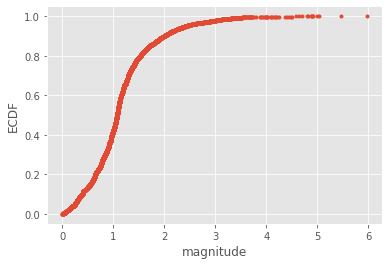

In [ ]:
# Create an array of earthquake magnitudes
mags = earthquakes.mag.values

# Make the plot
plt.plot(*dcst.ecdf(mags), marker='.', linestyle='none')
plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.show()

## Computing the b-value

The b-value is a common metric for the seismicity of a region. You can imagine you would like to calculate it often when working with earthquake data. For tasks like this that you will do often, it is best to write a function

In [ ]:
def b_value(mags, mt, perc=[2.5, 97.5], n_reps=None):
    """Compute the b-value and optionally its confidence interval."""
    # Extract magnitudes above completeness threshold: m
    m = mags[mags >= mt]

    # Compute b-value: b
    b = (np.mean(m) - mt) * np.log(10)

    # Draw bootstrap replicates
    if n_reps is None:
        return b
    else:
        m_bs_reps = dcst.draw_bs_reps(m, np.mean, size=n_reps)

        # Compute b-value from replicates: b_bs_reps
        b_bs_reps = (m_bs_reps - mt) * np.log(10)

        # Compute confidence interval: conf_int
        conf_int = np.percentile(b_bs_reps, perc)
    
        return b, conf_int

Because there are plenty of earthquakes above magnitude 3, you can use mt = 3 as your completeness threshold. With this completeness threshold, compute the b-value for the Parkfield region from 1950 to 2016, along with the 95% confidence interval. 

Overlay the theoretical Exponential CDF to verify that the Parkfield region follows the Gutenberg-Richter Law.

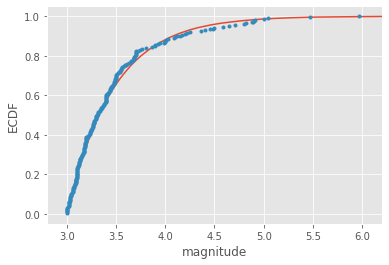


b-value: 1.08
95% conf int: [0.94, 1.24]


In [ ]:
mt = 3

# Compute b-value and confidence interval
b, conf_int = b_value(mags, mt, perc=[2.5, 97.5], n_reps=10000)

# Generate samples to for theoretical ECDF
m_theor = np.random.exponential(b/np.log(10), size=100000) + mt

# Plot the theoretical CDF
plt.plot(*dcst.ecdf(m_theor))
# Plot the ECDF (slicing mags >= mt)
plt.plot(*dcst.ecdf(mags[mags >= mt]), marker='.', linestyle='none')

# Pretty up and show the plot
plt.xlabel('magnitude')
plt.ylabel('ECDF')
plt.xlim(2.8, 6.2)
plt.show()

# Report the results
print("""
b-value: {0:.2f}
95% conf int: [{1:.2f}, {2:.2f}]""".format(b, *conf_int))

Parkfield seems to follow the Gutenberg-Richter law very well. The b-value of about 1 is typical for regions along fault zones.

## Models for earthquake timing

Exponential model for timing: Eartquakes happen like a Poisson process. Each independent to one another.

Gaussian or normal model: Earthquakes happen periodically.


### Filtering dataset for interearthquake times. 

In [ ]:
# New format: 'YYYY/MM/DD'
new_format = "%Y/%m/%d"
earthquakes.time = earthquakes.time.dt.strftime(new_format)

# Filter only for earthquakes with magnitude higher than 4
earthquakes = earthquakes[earthquakes.mag>4]
earthquakes.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc
5,1966/06/28,35.790500,-120.294000,6.000,5.47,ml,15.0,247.0,1.18300,0.48,ci,ci3330127,2017-04-26T17:23:14.375Z,"8km N of Cholame, CA",earthquake,3.51,31.61,0.075,8.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US
6,1966/06/28,35.950000,-120.500000,6.000,4.50,mh,NaN,NaN,NaN,NaN,ci,ci10086774,2016-01-28T19:54:08.270Z,"8km NW of Parkfield, CA",earthquake,NaN,NaN,NaN,0.0,reviewed,ci,ci,Coalinga,California,Fresno County,US
241,1967/08/12,35.774667,-120.328167,6.000,4.09,ml,14.0,246.0,1.21000,0.56,ci,ci3329531,2016-01-28T19:33:12.190Z,"6km NNW of Cholame, CA",earthquake,2.81,31.61,0.192,12.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US
278,1975/01/06,35.944333,-120.513667,9.673,4.40,ml,19.0,117.0,0.03243,0.12,nc,nc1022464,2016-12-14T23:10:17.990Z,Central California,earthquake,0.43,0.89,NaN,0.0,reviewed,nc,nc,Coalinga,California,Fresno County,US
324,1975/09/13,35.997667,-120.544833,10.405,4.80,ml,27.0,69.0,0.07748,0.07,nc,nc1026327,2016-12-15T03:13:33.590Z,Central California,earthquake,0.29,0.72,NaN,0.0,reviewed,nc,nc,Coalinga,California,Fresno County,US


In [ ]:
# Change object columns to datetime:
earthquakes['time'] = pd.to_datetime(earthquakes['time'])

# Compute time between events
earthquakes['time between earthq'] = pd.to_datetime(earthquakes.time.shift(1)) 
earthquakes['time between earthq'] = earthquakes.time - pd.to_datetime(earthquakes['time between earthq'])
earthquakes.head(2)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,id,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,loc_name,loc_admin1,loc_admin2,loc_cc,time between earthq
5,1966-06-28,35.7905,-120.294,6.0,5.47,ml,15.0,247.0,1.183,0.48,ci,ci3330127,2017-04-26T17:23:14.375Z,"8km N of Cholame, CA",earthquake,3.51,31.61,0.075,8.0,reviewed,ci,ci,Shandon,California,San Luis Obispo County,US,NaT
6,1966-06-28,35.9500,-120.500,6.0,4.50,mh,NaN,NaN,NaN,NaN,ci,ci10086774,2016-01-28T19:54:08.270Z,"8km NW of Parkfield, CA",earthquake,NaN,NaN,NaN,0.0,reviewed,ci,ci,Coalinga,California,Fresno County,US,0 days


In [ ]:
# Calculate time gap for events hith magnitude higher than 3.
time_gap = earthquakes['time between earthq'].dt.days.dropna().astype(int).values

# Sort np array
time_gap = np.sort(time_gap)
time_gap

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    1,    1,   60,  166,  168,  224,  250,  401,  410,  686,
        736, 1903, 2704, 2884, 6247])

Sample mean of time gap:  623.7407407407408


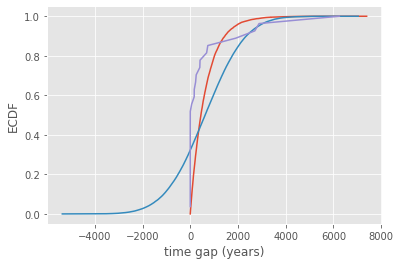

In [ ]:
# Compute the mean time gap: mean_time_gap
mean_time_gap = np.mean(time_gap)
print('Sample mean of time gap: ', mean_time_gap)

# Standard deviation of the time gap: std_time_gap
std_time_gap = np.std(time_gap)

# Generate theoretical Exponential distribution of timings: time_gap_exp
time_gap_exp = np.random.exponential(mean_time_gap, size=10000)
time_gap_norm = np.random.normal(mean_time_gap, std_time_gap, size=100000)

# Plot CDFs
plt.plot(*dcst.ecdf(time_gap_exp))
plt.plot(*dcst.ecdf(time_gap_norm))
plt.plot(*dcst.ecdf(time_gap))
plt.xlabel('time gap (years)')
plt.ylabel('ECDF')
plt.show()

It seems the distribution functions is closer to the exponential than the normal one.

## When will the next big Parkfield quake be assuming exponential?
What happens to the mean if time between events follow a normal distribution function?


 The best estimate is given by the mean time gap

 Compute 95% confidence intervals on when the next earthquake will be assuming an Exponential distribution **parametrized** by mean_time_gap

 Here we are looking for parametrized CI, if not we would make bootstrap replicas.

In [ ]:
# Draw samples from the Exponential distribution: exp_samples
exp_samples = np.random.exponential(mean_time_gap, size=100000)

# Draw samples from the Normal distribution: norm_samples
norm_samples = np.random.normal(mean_time_gap, std_time_gap, size=100000)

# Compute the confidence intervals with medians
conf_int_exp = np.percentile(exp_samples, [2.5, 50, 97.5])
conf_int_norm = np.percentile(norm_samples, [2.5, 50, 97.5]) 

# Print the results
print('Exponential:', conf_int_exp)
print('     Normal:', conf_int_norm)

Exponential: [  15.91277312  433.96452164 2289.73886975]
     Normal: [-2017.65753674   622.81414999  3258.65635676]


Standard deviation is really high due to small dataset. With this dataset we can't really draw conclusions, but the codes and what the analysis should be, stays the same.

## How are the Parkfield interearthquake times distributed? Kolgomorov-Smirnov Test


### K-S: Important experiment to do to a datasets. We can compare with different distributions beyond visual EDA. 

We saw the dataset distribution function could be an exponential function. But how we can measure how close empirical ECDF is to a theoretical CDF?

We will analyse the case computing a test statistic that follow the difference between those functions. Maximum of distances seems like a reasonable measure. This maximal distances has a name: The Kolmogorov-Smirnov statistic or K-S statistic.

Our hypothesis: The time between earthquakes is exponentially distributed with a mean and standard deviation as calculated from the data.

Test statistic: K-S statistic

p-test >= than observed K-S statistic

- First we draw and store lots (10000) samples out of the **theoretical** distribution

- Draw n samples out of the theoretical distribution.

- Compute the K-S statistic from the samples.

To be able to do the Kolmogorov-Smirnov test, we need to compute the value of a formal ECDF at arbitrary points. In other words, we need a function, ecdf_formal(x, data) that returns the value of the formal ECDF derived from the data set. 

The function is like this:

def ecdf_formal(x, data):
    return np.searchsorted(np.sort(data), x, side='right') / len(data)

In [ ]:
def ks_stat(data1, data2):
    # Compute ECDF from data: x, y
    x, y = dcst.ecdf(data1)
    
    # Compute corresponding values of the target CDF
    cdf = dcst.ecdf_formal(x, data2)

    # Compute distances between concave corners and CDF
    D_top = y - cdf

    # Compute distance between convex corners and CDF
    D_bottom = cdf - y + 1/len(data1)

    return np.max((D_top, D_bottom))

### Drawing K-S replicates

In [ ]:
def draw_ks_reps(n, f, args=(), size=10000, n_reps=10000):
    # Generate samples from target distribution
    x_f = f(*args, size=size)
    
    # Initialize K-S replicates
    reps = np.empty(n_reps)
    
    # Draw replicates
    for i in range(n_reps):
        # Draw samples for comparison
        x_samp = f(*args, size=n)
        
        # Compute K-S statistic
        reps[i] = dcst.ks_stat(x_samp, x_f)

    return reps

### The K-S test for Exponentiality

Test the null hypothesis that the interearthquake times of the Parkfield sequence are Exponentially distributed. That is, earthquakes happen at random with no memory of when the last one was. 

In [ ]:
# Draw target distribution: x_f
x_f = np.random.exponential(mean_time_gap, size=10000)

# Compute K-S stat: d
ks_stat = dcst.ks_stat(time_gap, x_f)

# Draw K-S replicates: reps
reps = dcst.draw_ks_reps(len(time_gap), np.random.exponential, 
                         args=(mean_time_gap,), size=10000, n_reps=10000)

# Compute and print p-value
p_val = np.sum(reps >= ks_stat) / 10000
print('p =', p_val)

p = 0.0


P-value is 0. This means there is no possibility the dataset has exponential distribution function.